In [81]:
import pandas as pd
import numpy as np
import nltk
import os
import nltk.corpus # sample text for performing tokenization
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
nltk.download('punkt')
from tqdm import tqdm
import numpy as np
import seaborn as sns

[nltk_data] Downloading package punkt to /Users/yunjaecho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Read data

In [83]:
jobs = pd.read_csv("job_training_data.csv")

# split by is fraud or not

In [14]:
fraud = jobs[jobs["fraudulent"] == 1]
fraud.to_csv("fraudulent.csv",index = False)
not_fraud = jobs[jobs["fraudulent"] == 0]
not_fraud.to_csv("not_fraudulent.csv",index = False)

# Length Counter
  - add columns that count the length of the text for each row

In [45]:
def length_counter(df,columns = ["company_profile","description","requirements","benefits"]):
    length = []
    for column in columns:
        df[(str(column) + "_length")] = df[column].apply(lambda x: len(x) if x == x else 0)
    return df

In [54]:
jobs = length_counter(jobs)
jobs = pd.get_dummies(jobs, columns = ['employment_type', "required_education", "required_experience","function."])
jobs_feature = jobs.iloc[:,9:]

In [56]:
jobs_feature = jobs_feature.drop("industry", axis = 1)

In [57]:
jobs_feature.to_csv("jobs_feature_noindustry.csv",index = False)

In [63]:
test = jobs_feature.loc[:,["company_profile_length","description_length","requirements_length","benefits_length","fraudulent"]]

In [67]:
nonfraud = test[test["fraudulent"] == 0]
fraud = test[test["fraudulent"] == 1]

In [70]:
nonfraud

,company_profile_length,description_length,requirements_length,benefits_length,fraudulent
0,2559,871,1383,100,0
1,829,391,88,16,0
2,1251,724,805,2047,0
3,829,838,0,0,0
4,0,92,35,17,0
...,...,...,...,...,...
5098,0,64,0,0,0
5099,726,975,648,898,0
5100,608,1852,0,0,0
5101,228,943,0,0,0


<AxesSubplot:xlabel='benefits_length', ylabel='Count'>

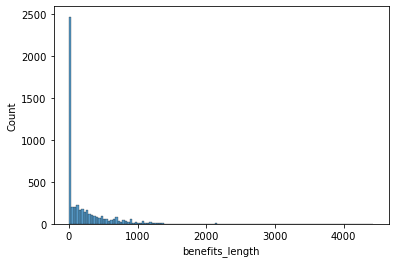

In [79]:
sns.histplot(x = "benefits_length",data = nonfraud)

<AxesSubplot:xlabel='benefits_length', ylabel='Count'>

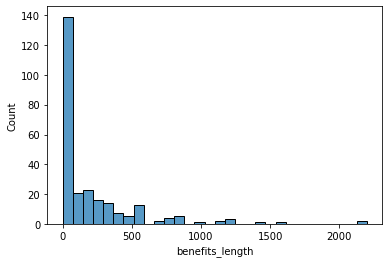

In [80]:
sns.histplot(x = "benefits_length",data = fraud)

# Frequency rules

In [87]:
stop_words = {".",'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'same',
 'shan',
 "shan't",
 'she',
 "she's",
 'should',
 "should've",
 'shouldn',
 "shouldn't",
 'so',
 'some',
 'such',
 't',
 'than',
 'that',
 "that'll",
 'the',
 'their',
 'theirs',
 'them',
 'themselves',
 'then',
 'there',
 'these',
 'they',
 'this',
 'those',
 'through',
 'to',
 'too',
 'under',
 'until',
 'up',
 've',
 'very',
 'was',
 'wasn',
 "wasn't",
 'we',
 'were',
 'weren',
 "weren't",
 'what',
 'when',
 'where',
 'which',
 'while',
 'who',
 'whom',
 'why',
 'will',
 'with',
 'won',
 "won't",
 'wouldn',
 "wouldn't",
 'y',
 'you',
 "you'd",
 "you'll",
 "you're",
 "you've",
 'your',
 'yours',
 'yourself',
 'yourselves',"us"}


In [19]:
def get_freq(text):
    tokens = word_tokenize(text.lower()) # needs punkt package
    # I also turned text to lower case
    num_tokens = len(tokens)
    
    fdist = FreqDist(tokens) # make frequency dictionary
    # remove unwanted words
    for word in stop_words:
        if word in fdist:
            fdist.pop(word)
    
    for t in fdist:
        fdist[t] = fdist[t] / num_tokens
        
    return fdist

# merge_and_tokenize
 - merge all the text and generate the frequency table that cotains only words with minimum count k. 

In [84]:
def merge_and_tokenize(df,column = "company_profile",k = 0):
    merged_text = []
    text_dict = {}
    parsed_row = []
    for sentence in df[column]:
        if sentence == sentence:
            words = sentence.lower().split()
            words = [w.strip().strip("'").strip('"').strip(",").strip("(").strip(")").strip(".").strip(";").strip(":") for w in words]
            for word in words: # remove stop words
                if "url" in str(word):
                    words.remove(word)
                if word in stop_words:
                    words.remove(word)
            parsed_row.append(words)
            merged_text.extend(words)
        else:
            parsed_row.append(np.nan)
            
    fdist = FreqDist(merged_text)
    
    keys = list(fdist.keys())
    
    for key in keys:
        if fdist[key] <= k:
            del fdist[key]
        else:
            fdist[key] =0
            
    return fdist,parsed_row

# parsed_frequency
 - return the list of frequency for each row

In [112]:
def parsed_frequency(freq_dic,parsed_text):
    parsed_dict = freq_dic.copy()
    freq_list = []
    
    for text in tqdm(parsed_text):
        parsed_dict = freq_dic.copy()
        if text == text:
            for word in text:
                if word in parsed_dict:
                    parsed_dict[word] += 1/len(text)
        else:
            freq_list.append(freq_dic)
            continue
        
        freq_list.append(parsed_dict)
        
    return freq_list

In [113]:
company_dict,parsed_company = merge_and_tokenize(jobs,"company_profile",10)
company_text_freq = parsed_frequency(company_dict,parsed_company)

100%|█████████████████████████████████████| 5362/5362 [00:01<00:00, 3099.75it/s]


In [114]:
description_dict,parsed_description = merge_and_tokenize(jobs,"description",10)
description_text_freq = parsed_frequency(description_dict,parsed_description) # list of freq for each row

100%|█████████████████████████████████████| 5362/5362 [00:02<00:00, 1887.07it/s]


In [115]:
requirements_dict,parsed_requirements = merge_and_tokenize(jobs,"requirements",3)
requirements_text_freq = parsed_frequency(requirements_dict,parsed_requirements)

100%|█████████████████████████████████████| 5362/5362 [00:03<00:00, 1587.09it/s]


In [116]:
benefits_dict,parsed_benefits = merge_and_tokenize(jobs,"benefits",3)
benefits_text_freq = parsed_frequency(benefits_dict,parsed_benefits)

100%|█████████████████████████████████████| 5362/5362 [00:01<00:00, 3169.61it/s]


In [124]:
company_text_freq = pd.DataFrame(company_text_freq)
description_text_freq = pd.DataFrame(description_text_freq)
requirements_text_freq = pd.DataFrame(requirements_text_freq)
benefits_text_freq = pd.DataFrame(benefits_text_freq)

In [128]:
company_text_freq

,working,fbn,put,farmers,first,every,decision,make,consider,impact,...,perks:expert,applicable)1,anyperkrelocation,candidatescontinued,bonues,"$2,000",referred/recruited,appointed,companyall,fraudulent
0,0.010676,0.017794,0.003559,0.035587,0.003559,0.007117,0.010676,0.007117,0.007117,0.010676,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0
1,0.011364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0
2,0.021127,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0
3,0.011364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5357,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1
5358,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1
5359,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1
5360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00885,0.00885,0.00885,0.00885,0.00885,0.00885,0.00885,0.00885,0.00885,1


In [125]:
company_text_freq["fraudulent"] = jobs["fraudulent"]
description_text_freq["fraudulent"] = jobs["fraudulent"]
requirements_text_freq["fraudulent"] = jobs["fraudulent"]
benefits_text_freq["fraudulent"] = jobs["fraudulent"]


In [127]:
company_text_freq.to_csv("company_text_freq.csv",index = False)
description_text_freq.to_csv("description_text_freq.csv",index = False)
requirements_text_freq.to_csv("requirements_text_freq.csv",index = False)
benefits_text_freq.to_csv("benefits_text_freq.csv",index = False)